## Adpatacion del codigo del tutorial a las imagenes de monet

In [207]:
'''tutorial.ipynb
https://www.tensorflow.org/tutorials/generative/dcgan?hl=es-419'''

'tutorial.ipynb\nhttps://www.tensorflow.org/tutorials/generative/dcgan?hl=es-419'

In [208]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [209]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import io
import zipfile
import PIL
from PIL import Image
from tensorflow.keras import layers
import time
from tqdm import tqdm
from IPython import display


### Adaptacion a nuestras imagenes

In [212]:
# Ruta al archivo zip
zip_file = 'gan-getting-started.zip'
target_folder = 'monet_jpg/'

def read_image_from_zip(zip_file, image_name):
    with zipfile.ZipFile(zip_file, 'r') as z:
        with z.open(image_name) as img_file:
            img = Image.open(io.BytesIO(img_file.read()))
            return img

# Listar archivos en la carpeta específica del zip
with zipfile.ZipFile(zip_file, 'r') as z:
    image_names = [name for name in z.namelist() if name.startswith(target_folder)]

# Leer todas las imágenes y convertirlas a arrays
images = []
for image_name in image_names:
    img = read_image_from_zip(zip_file, image_name)
    img = img.convert('RGB')  # Convertir a RGB
    img_array = np.array(img)
    images.append(img_array)

# Convertir la lista de imágenes a un array de NumPy
images = np.array(images)

# Normalizar las imágenes
images = images / 255.0

# Crear un dataset de TensorFlow
dataset = tf.data.Dataset.from_tensor_slices(images)


In [213]:
images.shape

(300, 256, 256, 3)

In [214]:
train_images_gray = np.mean(images, axis=-1)

# Expandir dimensiones para que sea (300, 256, 256, 1)
train_images_gray = np.expand_dims(train_images_gray, axis=-1)

# Normalizar las imágenes a [-1, 1]
train_images_gray = (train_images_gray - 127.5) / 127.5
train_images = train_images_gray.astype('float32')

In [215]:
train_images[1].shape

(256, 256, 1)

train_images = (images - 127.5) / 127.5
train_images = train_images.astype('float32')

In [216]:
BUFFER_SIZE = len(train_images)
BATCH_SIZE = 20

In [217]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Modelos

In [218]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(64*64*64, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((64, 64, 64)))
    assert model.output_shape == (None, 64, 64, 64)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128,128, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 256, 256, 1)

    return model


#### Generate random noise

In [219]:
generator = make_generator_model()
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 262144)         │    26,214,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 262144)         │     1,048,576 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 64)     │        65,536 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 32)   │        32,768 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 256, 256, 1)    │           512 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,362,176 (104.38 MB)

 Trainable params: 26,837,696 (102.38 MB)

 Non-trainable params: 524,480 (2.00 MB)

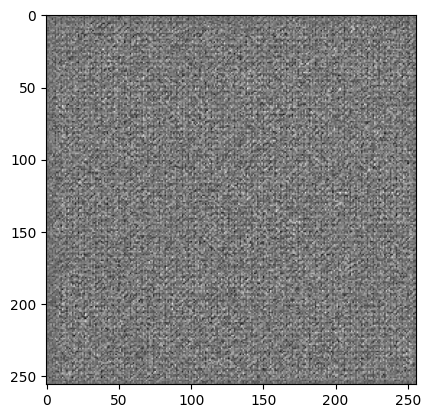

In [220]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [239]:
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-1.1123979 ,  0.6002348 , -1.3433229 , -0.23609726,  0.53589725,
         0.5787393 , -1.4863677 , -1.1835872 ,  0.17870332,  0.93594337,
         1.6418014 ,  0.42765382,  0.1438114 , -0.07865447,  0.11027547,
        -1.4599051 , -1.4279164 ,  0.40447453, -0.07687466, -0.93550724,
         2.3971972 , -0.70407885, -0.5841996 ,  0.7103355 , -1.7552998 ,
         1.0962319 , -0.00450572,  1.3499483 ,  0.25383526, -1.0356331 ,
        -1.2576829 ,  1.7308815 ,  0.11377089,  0.6705894 ,  1.1844559 ,
        -0.05736338, -0.8871801 , -0.22338122,  0.96838164,  1.0121034 ,
        -0.8719238 , -0.38323763, -0.09125645, -0.77538246,  0.65693337,
        -0.47622114,  1.0489515 , -1.6114511 , -0.30653504, -1.5229838 ,
         0.99257195, -1.193262  , -1.4839253 , -1.4793129 , -0.89850575,
        -0.61165065,  3.039232  ,  1.531453  , -0.91961294, -1.0395576 ,
        -3.01656   , -0.17572293,  0.9031575 ,  2.5995474 ,  0.2102543 ,
 

In [221]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[256, 256, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [222]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)


tf.Tensor([[0.00054522]], shape=(1, 1), dtype=float32)


## Funciones de perdida

In [223]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [224]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [225]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [226]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [227]:
checkpoint_dir = './monet_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


## Training loop

In [228]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [229]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    ### aca es donde en vez de noise le deberian entrar las otras imagenes normales
    ### y al discriminador le deberiamos mostrar las imagenes de las pinturas

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [230]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


In [231]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('monet_images\\image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


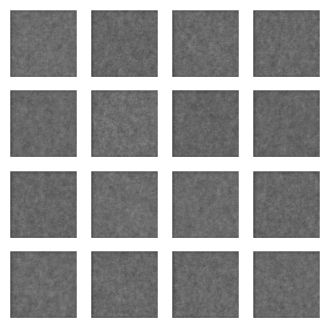

In [232]:
train(train_dataset, EPOCHS)

In [233]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [234]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('monet_images\\image_at_epoch_{:04d}.png'.format(epoch_no))


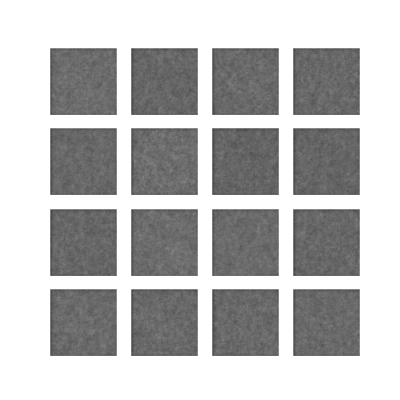

In [235]:
display_image(EPOCHS)


In [237]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('monet_images\\image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


C:\Users\queen\AppData\Local\Temp\ipykernel_7016\2525525224.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\queen\AppData\Local\Temp\ipykernel_7016\2525525224.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [238]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)


ModuleNotFoundError: No module named 'tensorflow_docs'